In [1]:
# @title Imports
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as td
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import trange

/home/usrs/pt_shimizu/work/sbsde/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title モデルの定義


def timestep_embedding(timesteps, dim, max_period=1000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32)
        / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class FCResNet(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_res_blocks):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.map = nn.Linear(data_dim, hidden_dim)
        self.res_blocks = nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)]
        )

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        return linear

    def build_res_block(self):
        hid = self.hidden_dim
        layers = []
        widths = [hid] * 4
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(nn.SiLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        h = self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h


class ToyModel(torch.nn.Module):
    def __init__(self, data_dim=2, hidden_dim=256, time_embed_dim=128):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        hid = hidden_dim

        self.t_module = nn.Sequential(
            nn.Linear(self.time_embed_dim, hid),
            nn.SiLU(),
            nn.Linear(hid, hid),
        )

        self.x_module = FCResNet(data_dim, hidden_dim, num_res_blocks=3)

        self.out_module = nn.Sequential(
            nn.Linear(hid, hid),
            nn.SiLU(),
            nn.Linear(hid, data_dim),
        )

    def forward(self, t, x):
        t = t.squeeze()
        if t.dim() == 0:
            t = t.repeat(x.shape[0])
        assert t.dim() == 1 and t.shape[0] == x.shape[0]

        t_emb = timestep_embedding(t, self.time_embed_dim)
        t_out = self.t_module(t_emb)
        x_out = self.x_module(x)
        out = self.out_module(x_out + t_out)
        return out

In [3]:
# @title utils
def flatten_dim01(x: torch.Tensor):
    return x.reshape(-1, *x.shape[2:])


def compute_div(os, xs):
    eps = torch.randn_like(xs)
    e_do_dx = torch.autograd.grad(os, xs, eps, create_graph=True, retain_graph=True)[0]
    div = e_do_dx * eps
    return div

In [4]:
# @title 分布の定義


class MixMultiVariateNormal:
    def __init__(self, batch_size, radius=12, num=8, sigmas=None, device="cpu"):
        arc = 2 * np.pi / num
        xs = [np.cos(arc * idx) * radius for idx in range(num)]
        ys = [np.sin(arc * idx) * radius for idx in range(num)]
        mus = [torch.tensor([x, y], device=device) for x, y in zip(xs, ys)]
        dim = len(mus[0])
        sigmas = (
            [torch.eye(dim, device=device) for _ in range(num)]
            if sigmas is None
            else sigmas
        )

        if batch_size % num != 0:
            raise ValueError("batch size must be devided by number of gaussian")
        self.num = num
        self.batch_size = batch_size
        self.dists = []
        for mu, sigma in zip(mus, sigmas):
            dist = td.multivariate_normal.MultivariateNormal(mu, sigma)
            dist._unbroadcasted_scale_tril = dist._unbroadcasted_scale_tril.double()
            self.dists.append(dist)

    def log_prob(self, x):
        # assume equally-weighted
        densities = [torch.exp(dist.log_prob(x.double())) for dist in self.dists]
        return torch.log(sum(densities) / len(self.dists))

    def sample(self, n=None):
        n = self.batch_size if n is None else n
        ind_sample = n / self.num
        samples = [dist.sample([int(ind_sample)]) for dist in self.dists]
        samples = torch.cat(samples, dim=0)
        return samples.float()

    def sample_n(self, n):
        ind_sample = n / self.num
        samples = [dist.sample([int(ind_sample)]) for dist in self.dists]
        samples = torch.cat(samples, dim=0)
        return samples.float()

In [5]:
# @title SDEの定義


class SDE:
    def __init__(
        self, p_data, p_prior, device, t0=1e-3, T=1, interval=100, num_stage=50
    ):
        self.p_data = p_data
        self.p_prior = p_prior
        self.device = device

        self.t0 = t0
        self.T = T
        self.interval = interval
        self.ts = torch.linspace(t0, T, interval, device=device)
        self.dt = T / interval
        self.num_stage = num_stage

        self.u_phi = ToyModel().to(device)
        self.s_theta = ToyModel().to(device)

        self.opt_phi = optim.AdamW(self.u_phi.parameters(), lr=1e-4)
        self.opt_theta = optim.AdamW(self.s_theta.parameters(), lr=1e-4)

    def forward_step(self, t, x, u=None):
        pass

    def backward_step(self, t, x, u=None):
        pass

    def make_train_phi(self):
        self.u_phi.train()
        for p in self.u_phi.parameters():
            p.requires_grad_(True)

    def make_train_theta(self):
        self.s_theta.train()
        for p in self.s_theta.parameters():
            p.requires_grad_(True)

    def make_eval_phi(self):
        self.u_phi.eval()
        for p in self.u_phi.parameters():
            p.requires_grad_(False)

    def make_eval_theta(self):
        self.s_theta.eval()
        for p in self.s_theta.parameters():
            p.requires_grad_(False)

    def sample_traj(self):
        x = self.p_data.sample().to(self.device)
        x.requires_grad_(True)
        xs = torch.zeros(x.shape[0], len(self.ts), x.shape[1], device=self.device)
        us = torch.zeros_like(xs)

        for i, t in enumerate(self.ts):
            u = self.u_phi(t, x)
            x = self.forward_step(t, x, u=u)
            xs[:, i] = x
            us[:, i] = u
        x_term = x
        return xs, us, x_term

    def compute_loss_phi(self):
        pass

    def compute_loss_theta(self):
        pass

    def train(self, each_num_iter):
        for stage in range(self.num_stage):
            print(f"stage {stage}")
            # stage1 : optimization for phi
            self.make_train_phi()
            self.make_eval_theta()
            pbar = trange(each_num_iter, desc="Optimize phi")
            for _ in pbar:
                self.opt_phi.zero_grad()
                loss = self.compute_loss_phi()
                loss.backward()
                self.opt_phi.step()
                pbar.set_postfix(loss=loss.item())

            # stage2 : optimization for theta
            self.make_eval_phi()
            self.make_train_theta()
            pbar = trange(each_num_iter, desc="Optimize theta")
            for _ in pbar:
                self.opt_theta.zero_grad()
                loss = self.compute_loss_theta()
                loss.backward()
                self.opt_theta.step()
                pbar.set_postfix(loss=loss.item())
            self.sample_plot()

    @torch.no_grad()
    def sample_plot(self, out_path=None, n=2000):
        self.make_eval_phi()
        self.make_eval_theta()
        x_data = self.p_data.sample_n(n).to(self.device)
        x = x_data
        for t in self.ts:
            x = self.forward_step(t, x)
        x_T = x.detach().cpu().numpy()

        x_prior = self.p_prior.sample_n(n).to(self.device)
        x = x_prior
        for t in reversed(self.ts):
            x = self.backward_step(t, x)
        x_0 = x.detach().cpu().numpy()

        x_data = x_data.detach().cpu().numpy()
        x_prior = x_prior.detach().cpu().numpy()

        _, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes[0, 0].plot(x_data[:, 0], x_data[:, 1], "o")
        axes[0, 0].set_title("p_data")
        axes[0, 1].plot(x_T[:, 0], x_T[:, 1], "o")
        axes[0, 1].set_title("p_T")
        axes[0, 2].plot(x_prior[:, 0], x_prior[:, 1], "o")
        axes[0, 2].set_title("p_prior")

        axes[1, 0].plot(x_prior[:, 0], x_prior[:, 1], "o")
        axes[1, 0].set_title("p_prior")
        axes[1, 1].plot(x_0[:, 0], x_0[:, 1], "o")
        axes[1, 1].set_title("p_0")
        axes[1, 2].plot(x_data[:, 0], x_data[:, 1], "o")
        axes[1, 2].set_title("p_data")
        for i in range(2):
            for j in range(3):
                axes[i, j].set_xlim(-20, 20)
                axes[i, j].set_ylim(-20, 20)
        if out_path is not None:
            plt.savefig(out_path)
        plt.show()

In [6]:
# @title common

batch_size = 80
each_num_step = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p_data = MixMultiVariateNormal(batch_size, radius=12, num=8, device=device)
p_prior = MixMultiVariateNormal(batch_size, radius=6, num=2, device=device)

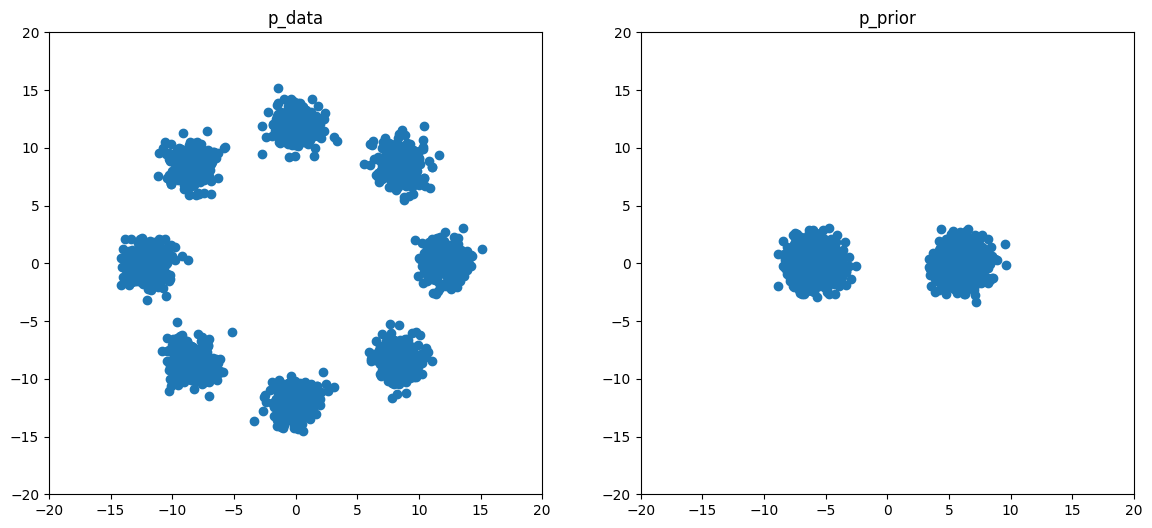

In [7]:
x_data = p_data.sample(2000).cpu().numpy()
x_prior = p_prior.sample(2000).cpu().numpy()

_, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_data[:, 0], x_data[:, 1], "o")
axes[0].set_title("p_data")
axes[1].plot(x_prior[:, 0], x_prior[:, 1], "o")
axes[1].set_title("p_prior")
for i in range(2):
    axes[i].set_xlim(-20, 20)
    axes[i].set_ylim(-20, 20)
plt.show()
plt.close()

### Stochastic optimal control 

$g(t) = 1.0$

- Forward
$$
d X_t = u_\phi(t, X_t) dt + d W_t, \quad X_0 \sim \mu
$$

- Backward
$$
d X_t = \mathbf{s}_\theta(t, X_t) dt + d W_t, \quad X_T \sim \pi
$$

Loss

$$
\min_{\phi, \theta} \, \mathbb{E}_X \left[ -\log \pi(X_T) + \int_0^T \left( \frac{1}{2} ||\mathbf{u}_\phi(t, X_t) + \mathbf{s}_\theta(t, X_t)||^2 + \nabla \cdot \mathbf{s}_\theta(t, X_t) \right) \right]
$$


In [8]:
# @title


class SOC(SDE):
    def forward_step(self, t, x, u=None):
        if u is None:
            u = self.u_phi(t, x)
        dX = u * self.dt + torch.randn_like(x) * np.sqrt(self.dt)
        return x + dX

    def backward_step(self, t, x):
        s = self.s_theta(t, x)
        dX = -s * self.dt + torch.randn_like(x) * np.sqrt(self.dt)
        return x - dX

    def _compute_loss(self):
        x, u, x_term = self.sample_traj()
        t = self.ts.repeat(batch_size)
        x = flatten_dim01(x)
        u = flatten_dim01(u)
        s = self.s_theta(t, x)

        integrand = 0.5 * (s + u) ** 2 + compute_div(s, x)
        E_integrand = integrand.reshape(
            x_term.shape[0], self.interval, x_term.shape[-1]
        ).mean(dim=0)
        loss = -self.p_prior.log_prob(x_term).mean() + (E_integrand * self.dt).sum()
        return loss

    def compute_loss_phi(self):
        return self._compute_loss()

    def compute_loss_theta(self):
        return self._compute_loss()


def train_and_plot_soc(each_num_step):
    soc = SOC(p_data, p_prior, device)
    soc.train(each_num_step)

stage 0


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=16.7]


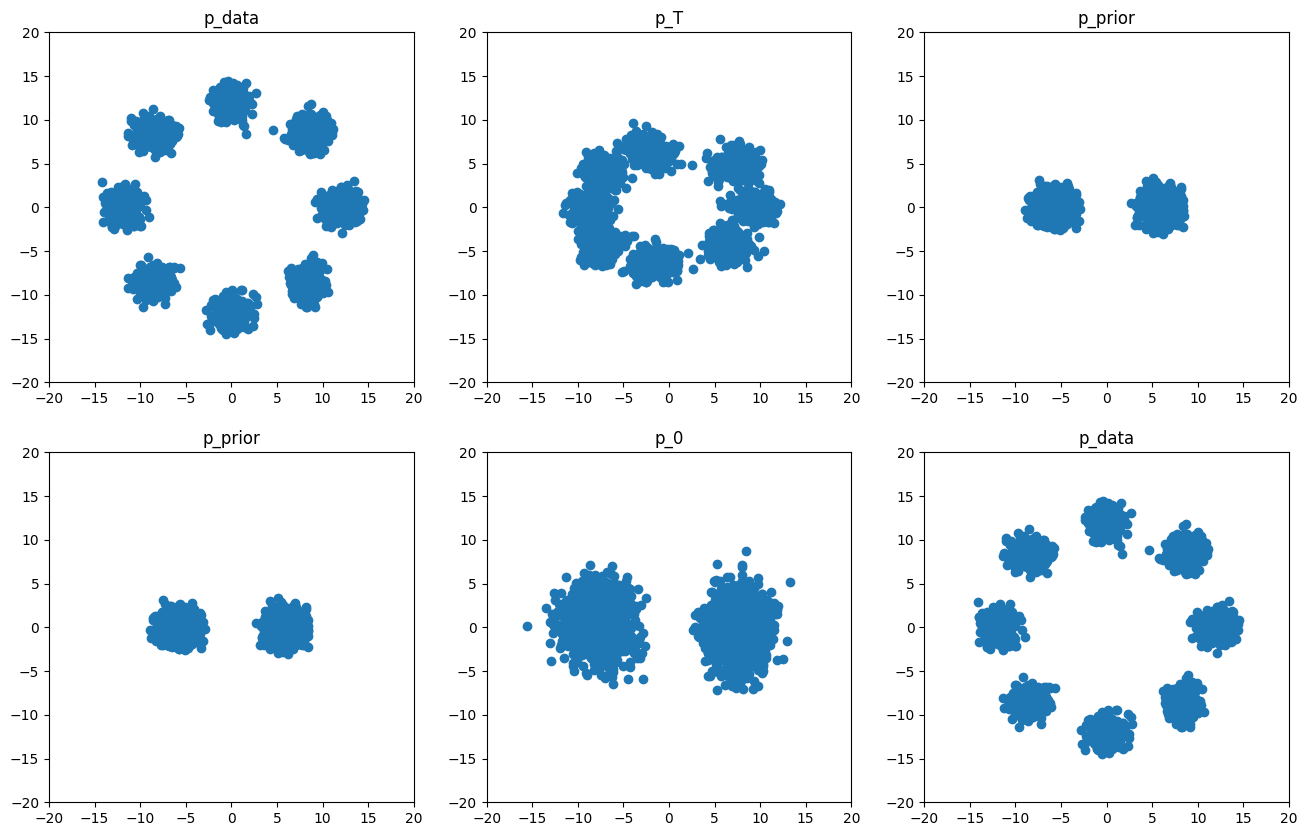

stage 1


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s, loss=10.7]


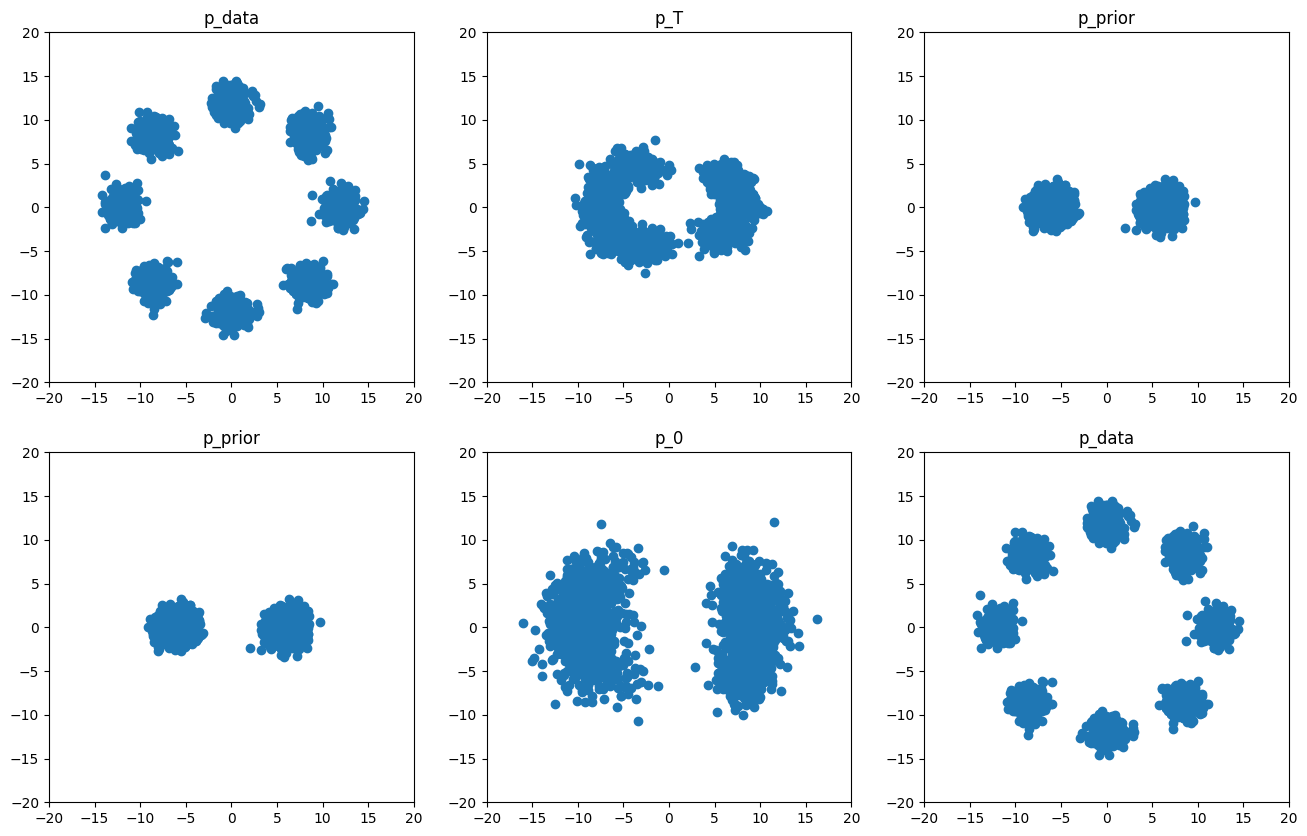

stage 2


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s, loss=7.68]


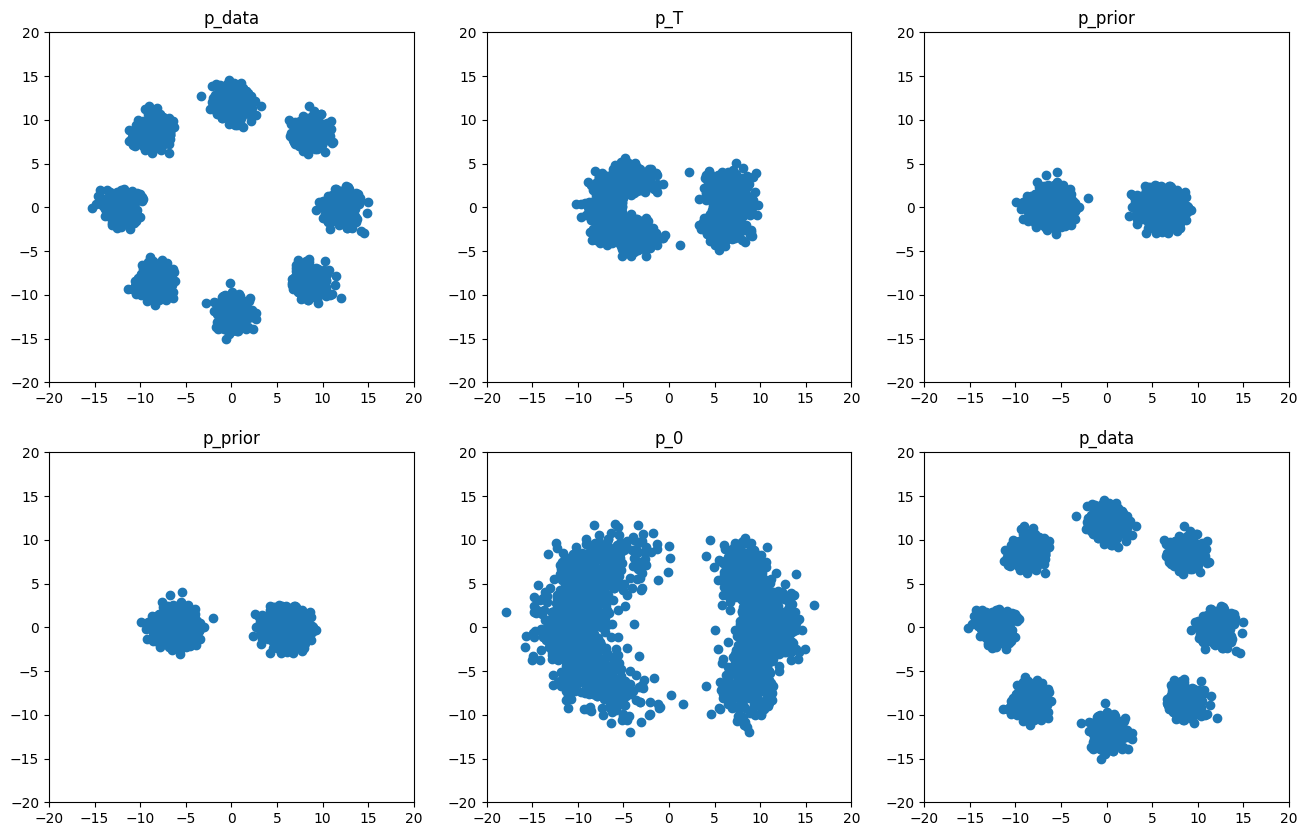

stage 3


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=6.43]


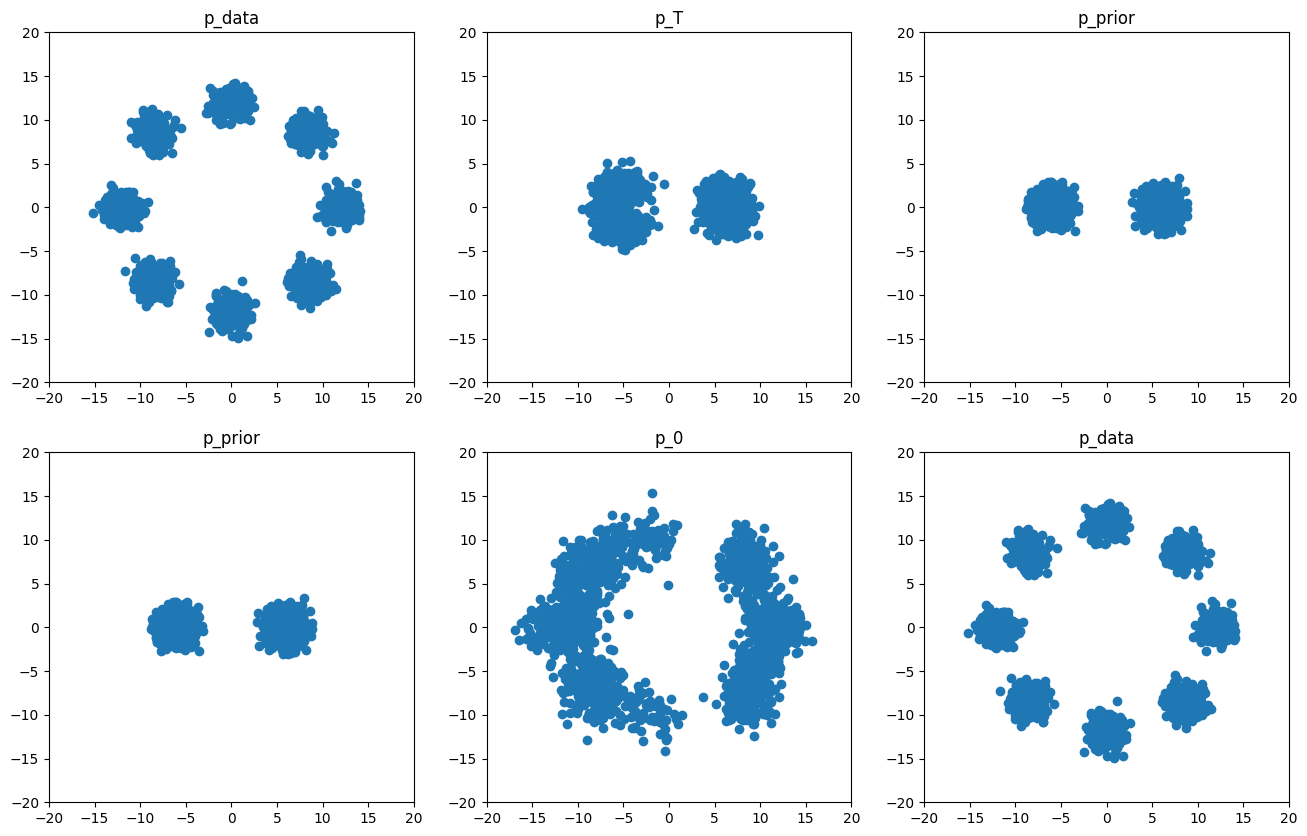

stage 4


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s, loss=6.07]


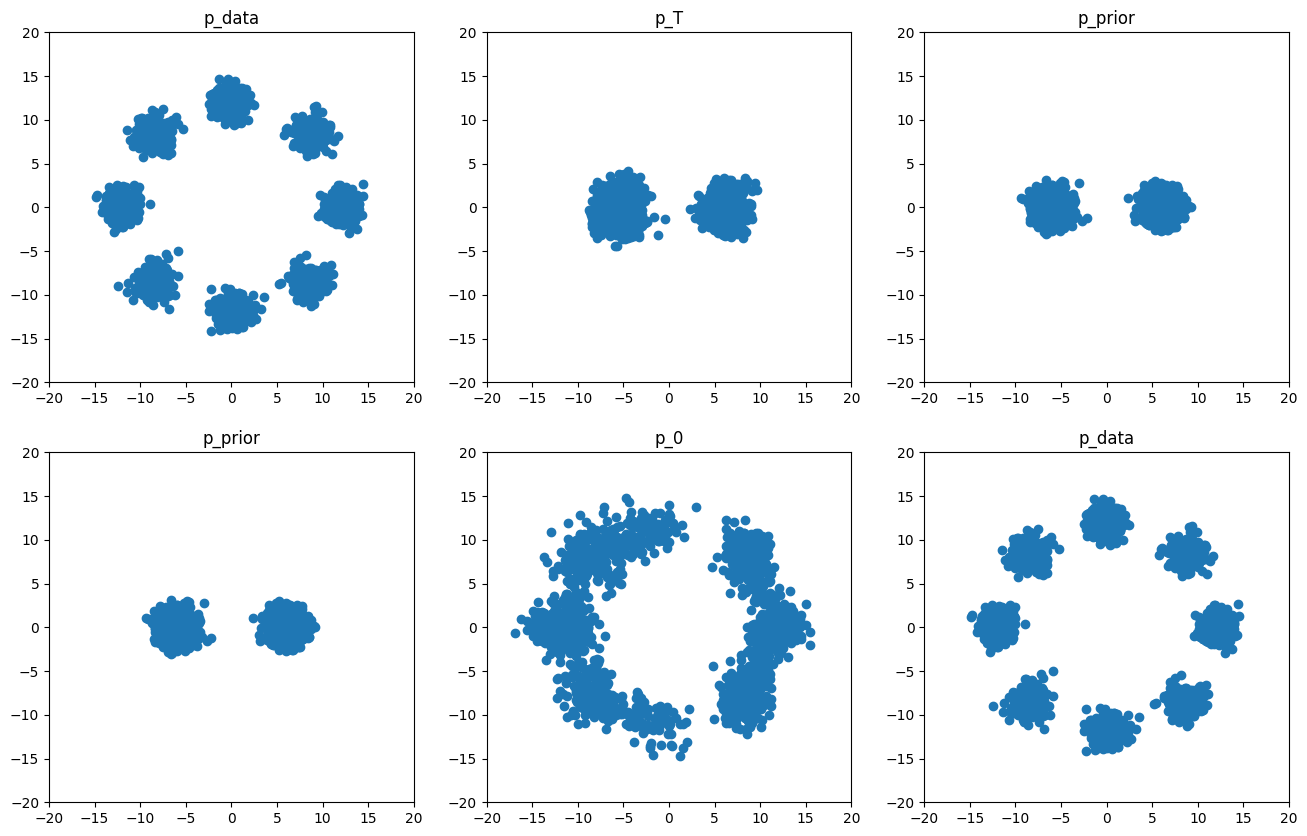

stage 5


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s, loss=5.3]


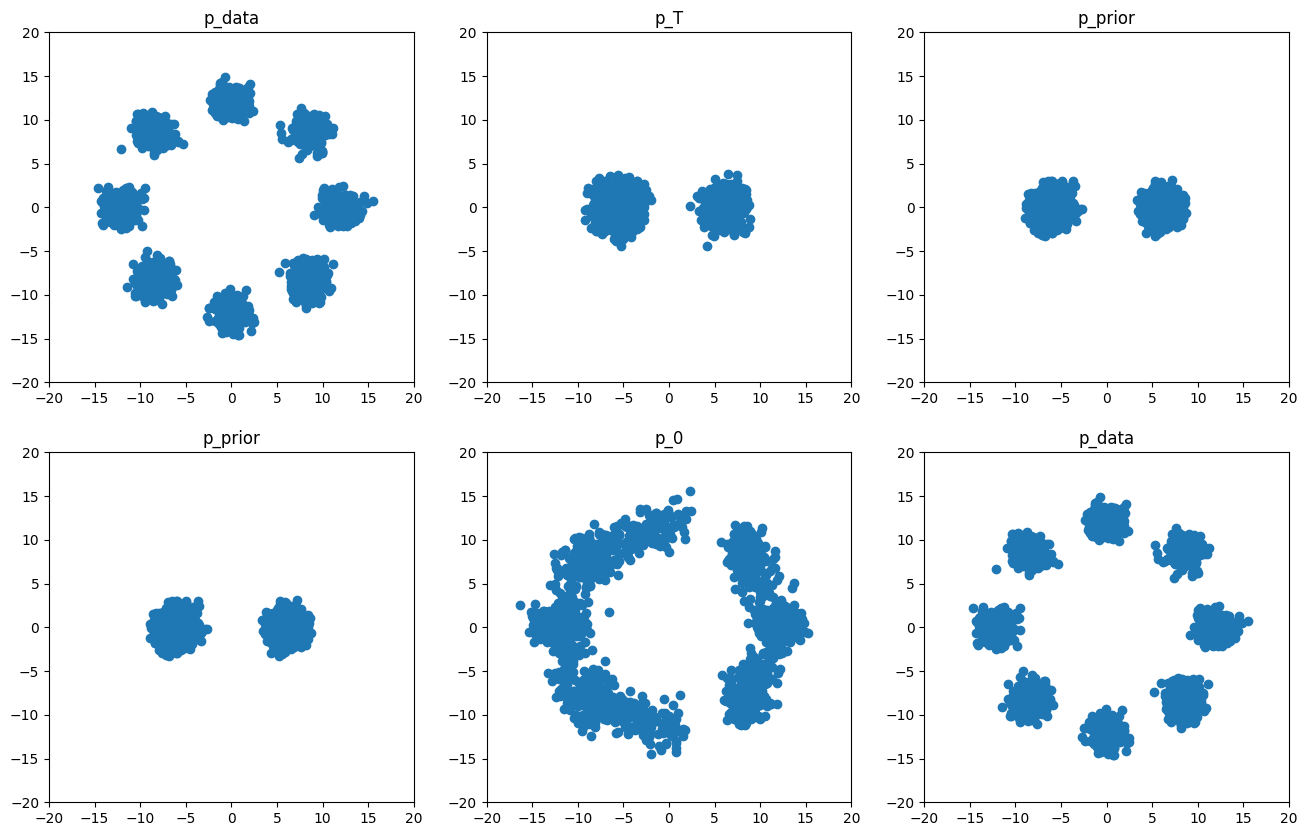

stage 6


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=5.61]


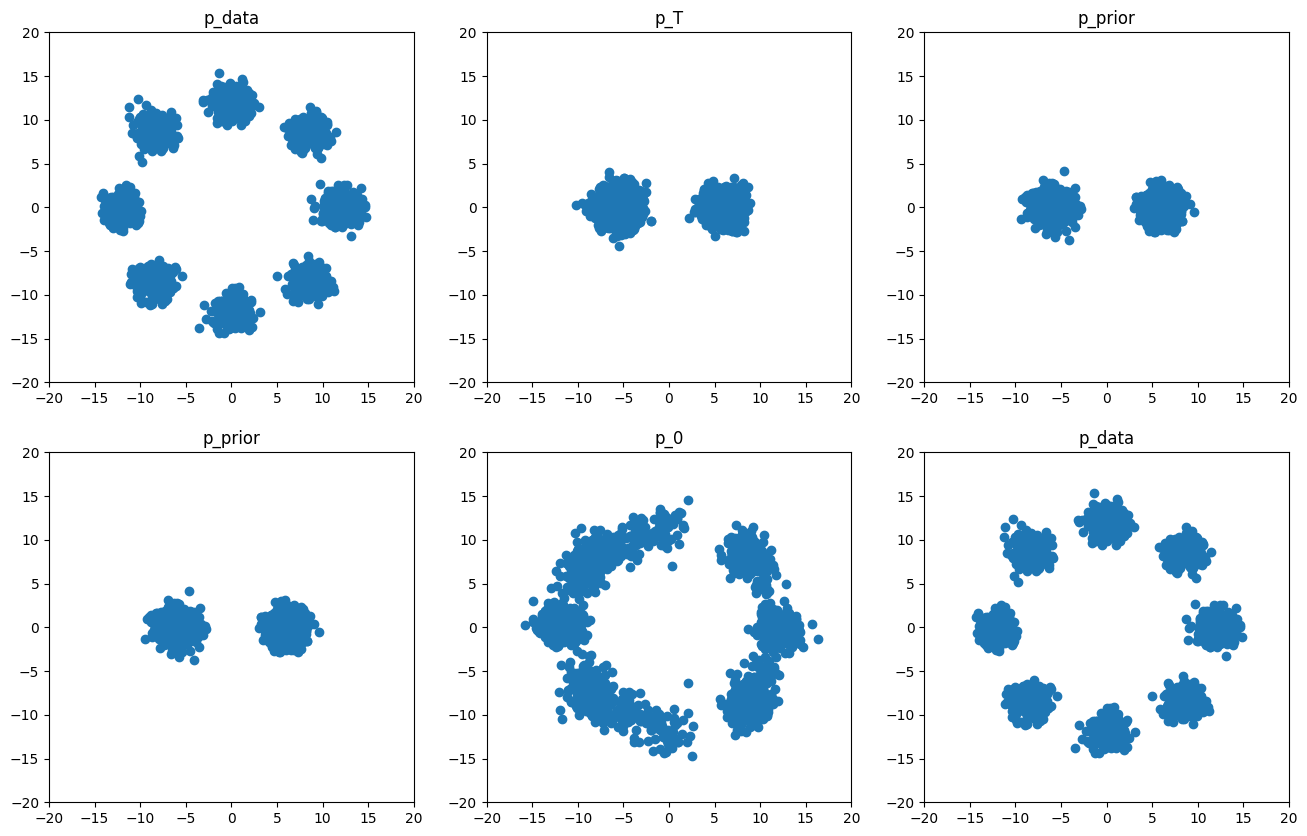

stage 7


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s, loss=5.44]


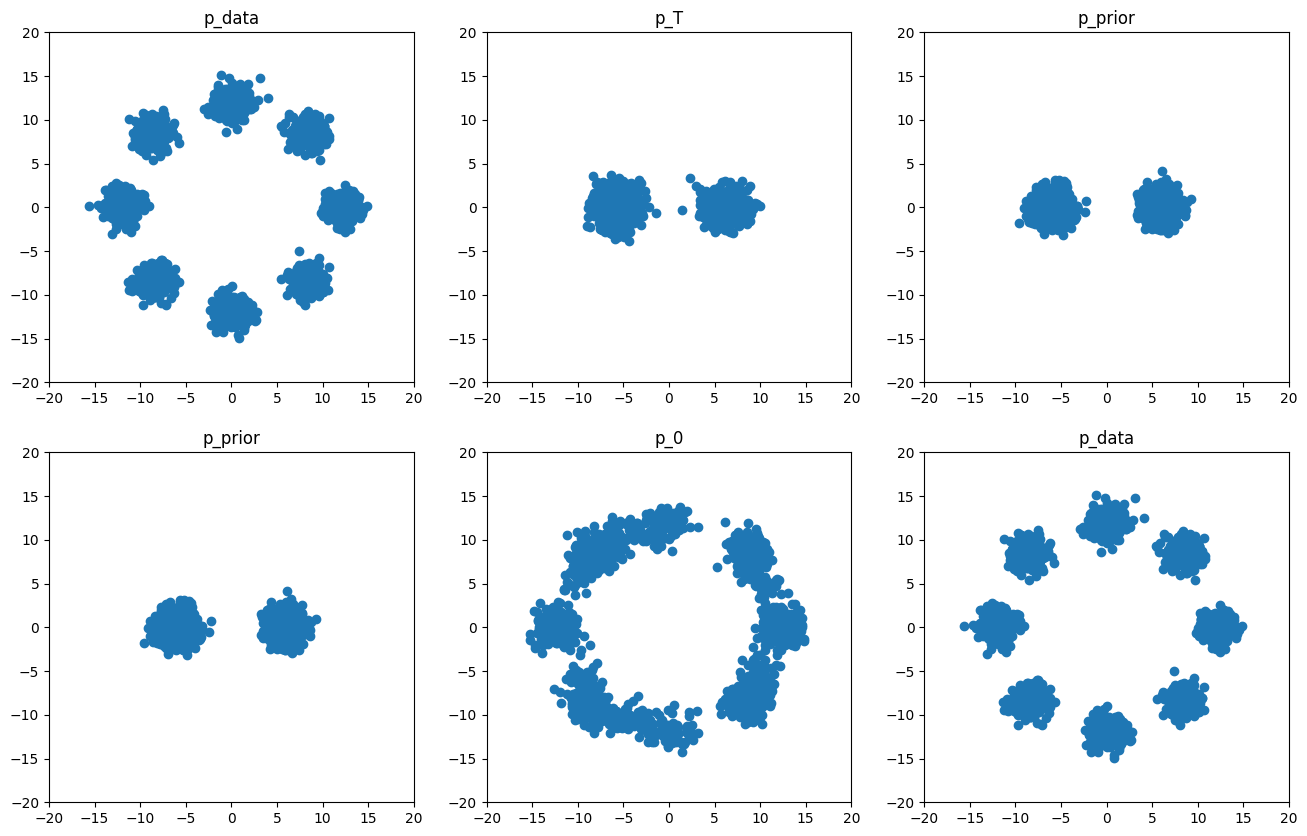

stage 8


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=5.84]


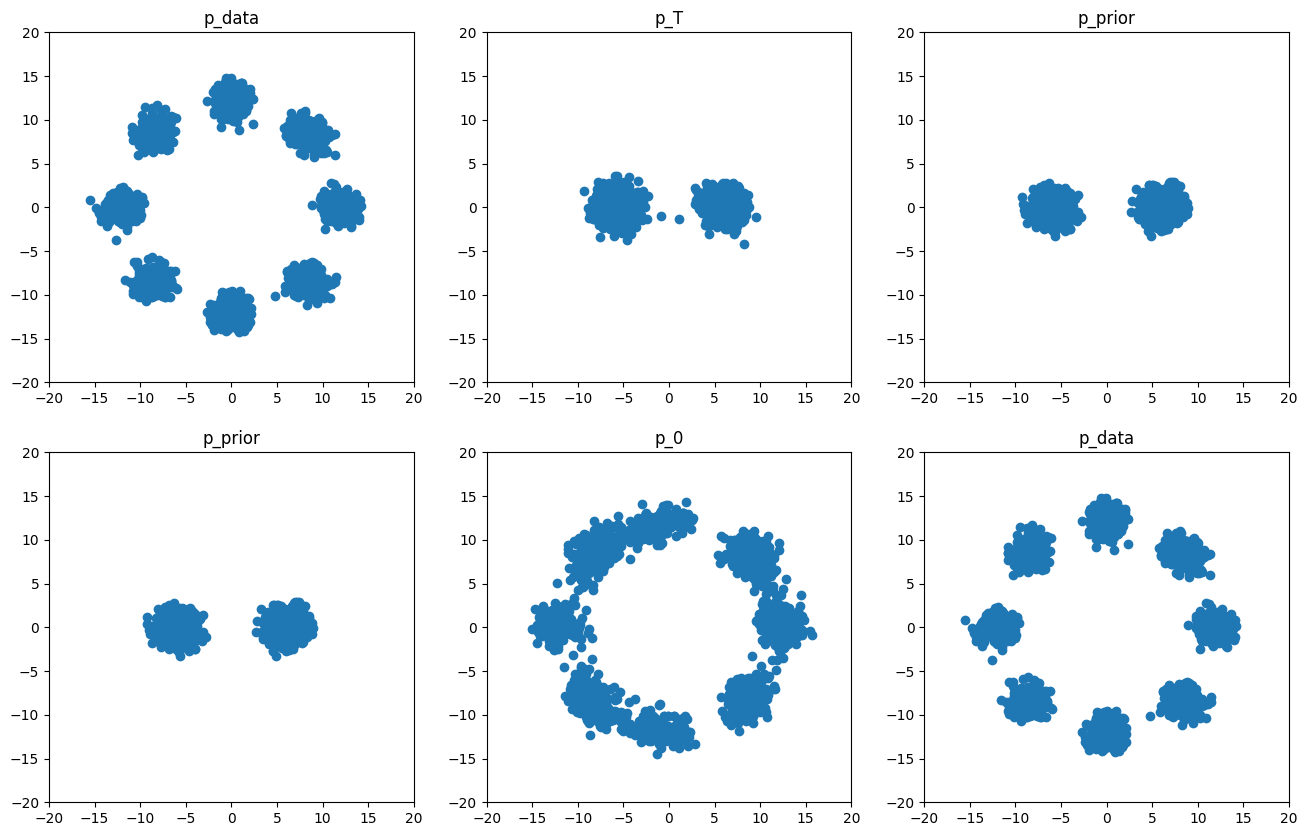

stage 9


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s, loss=5.34]


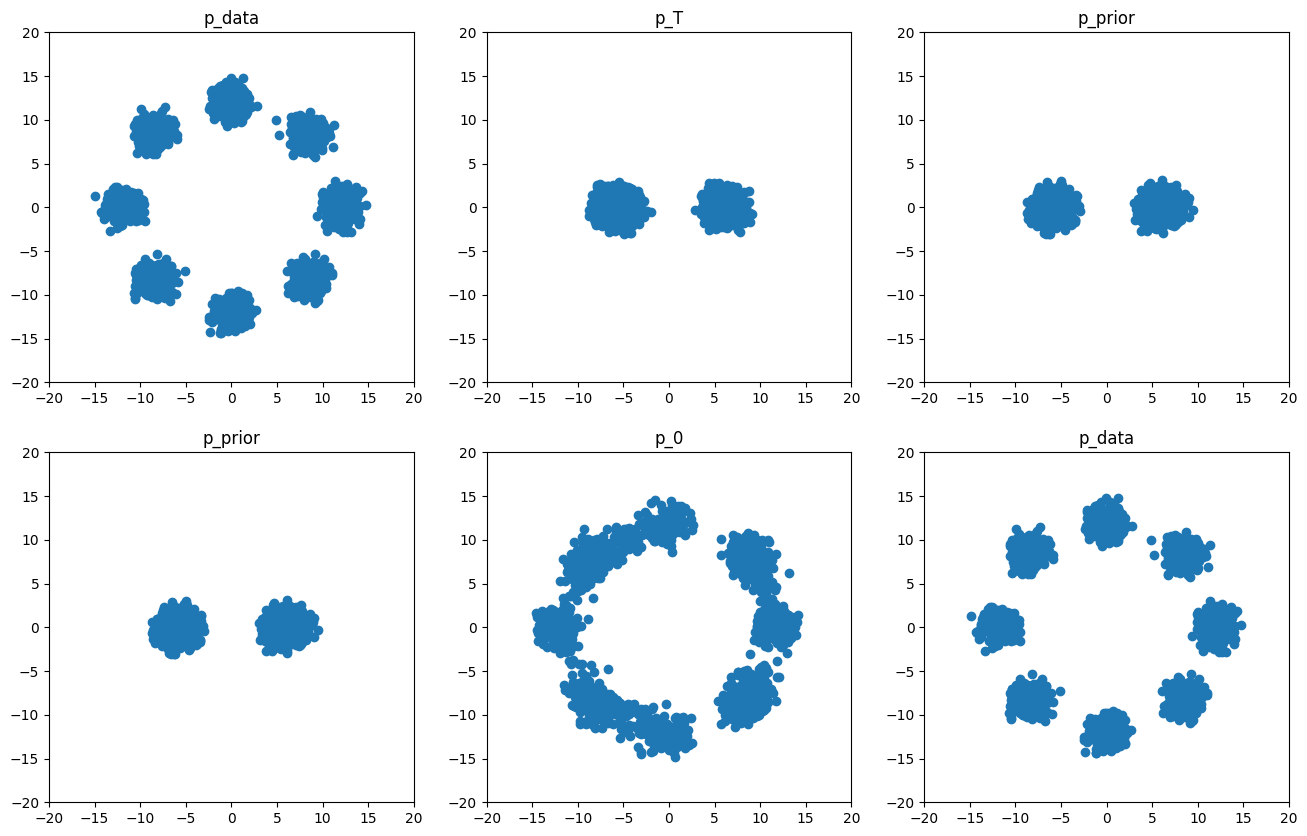

stage 10


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=5.27]


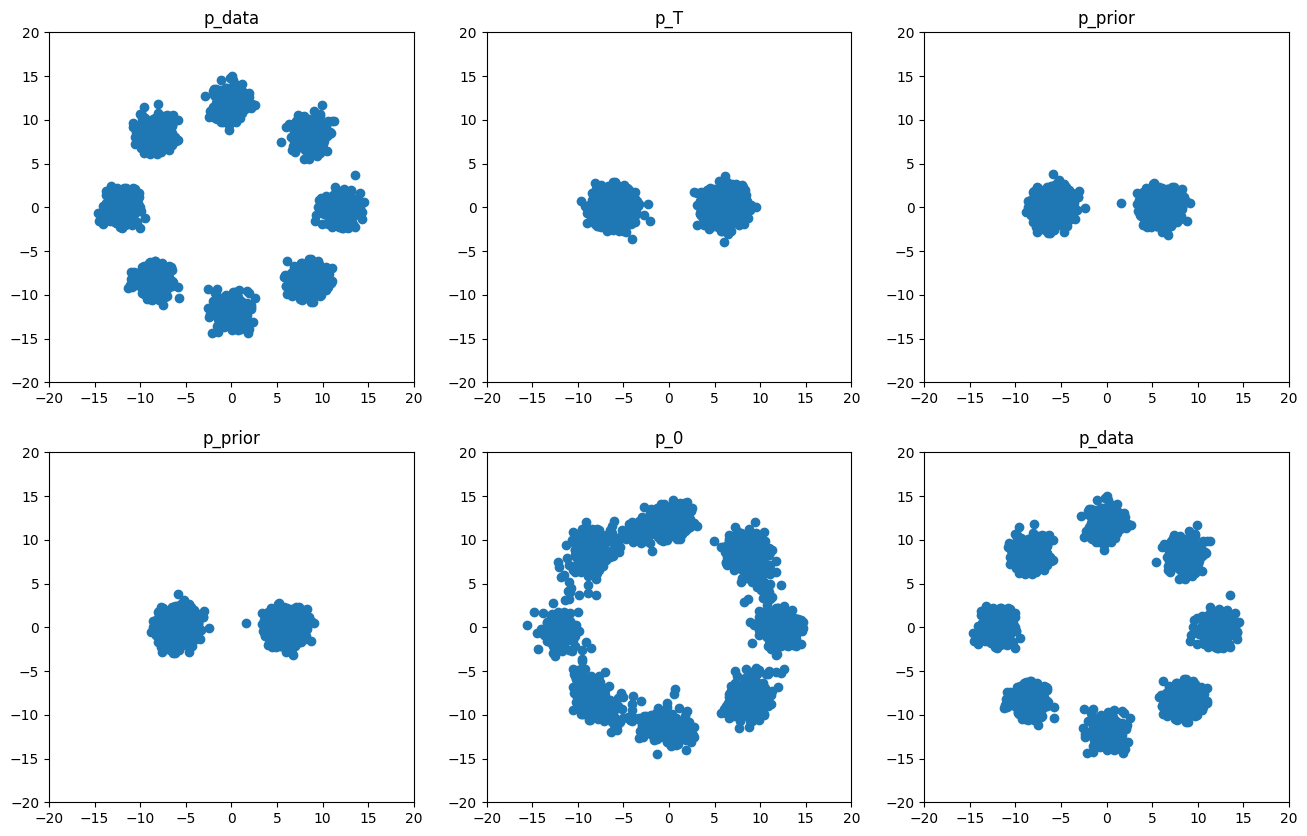

stage 11


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s, loss=4.94]


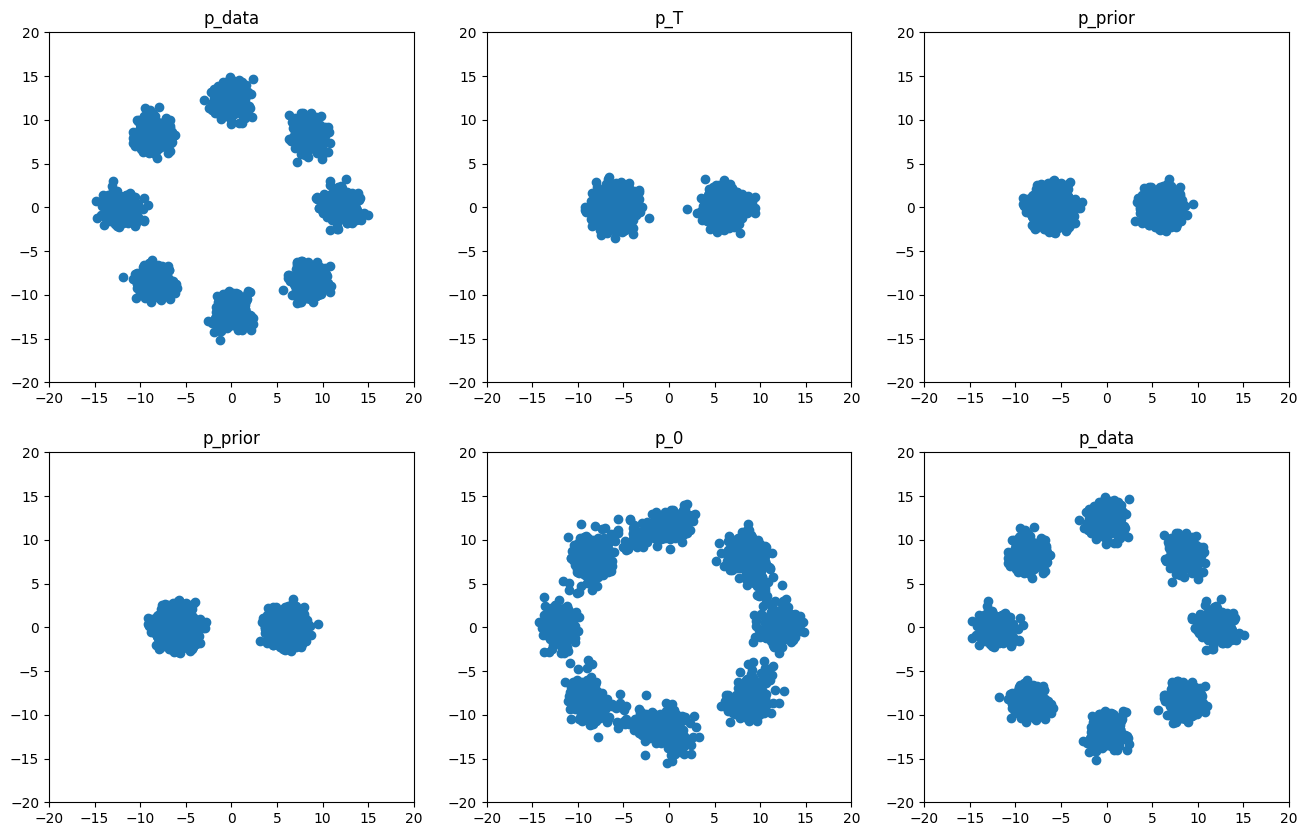

stage 12


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=5.31]


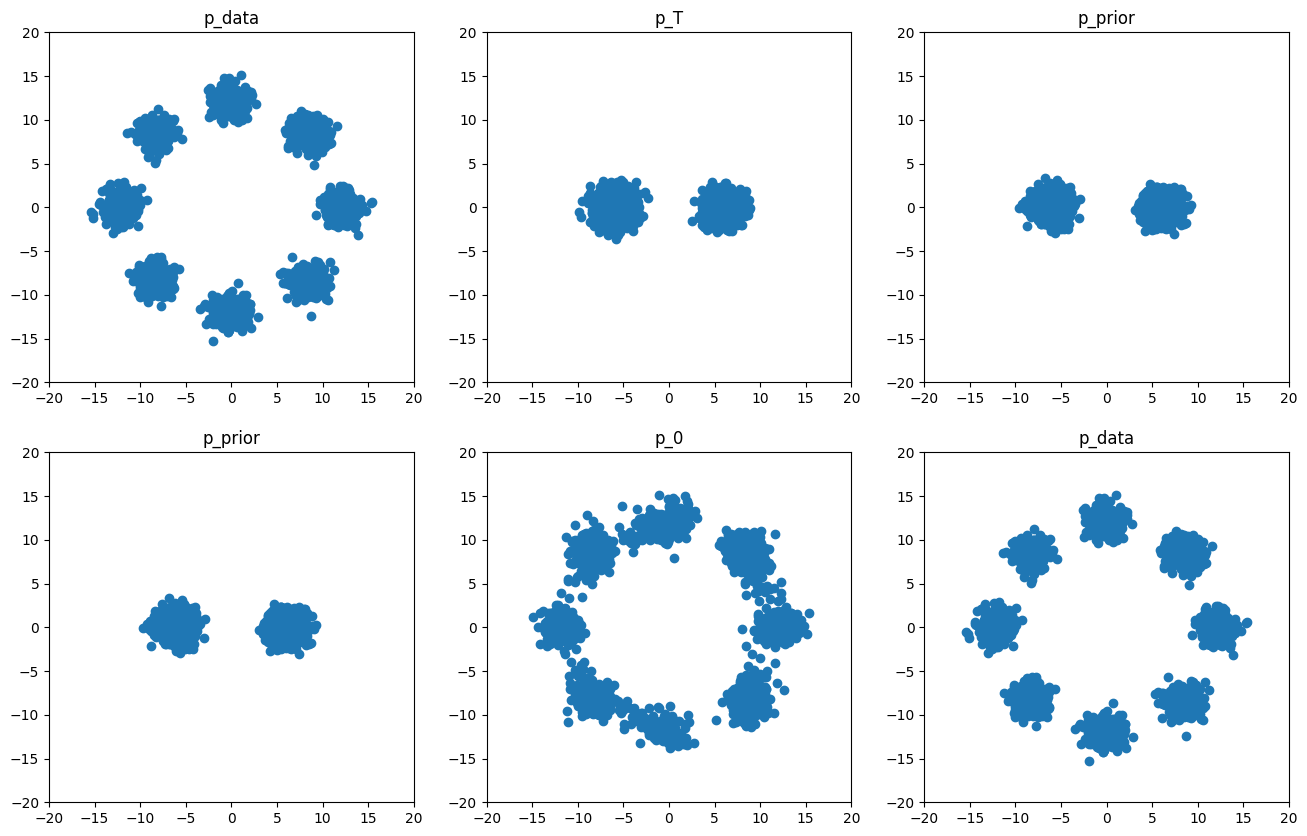

stage 13


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s, loss=5.65]


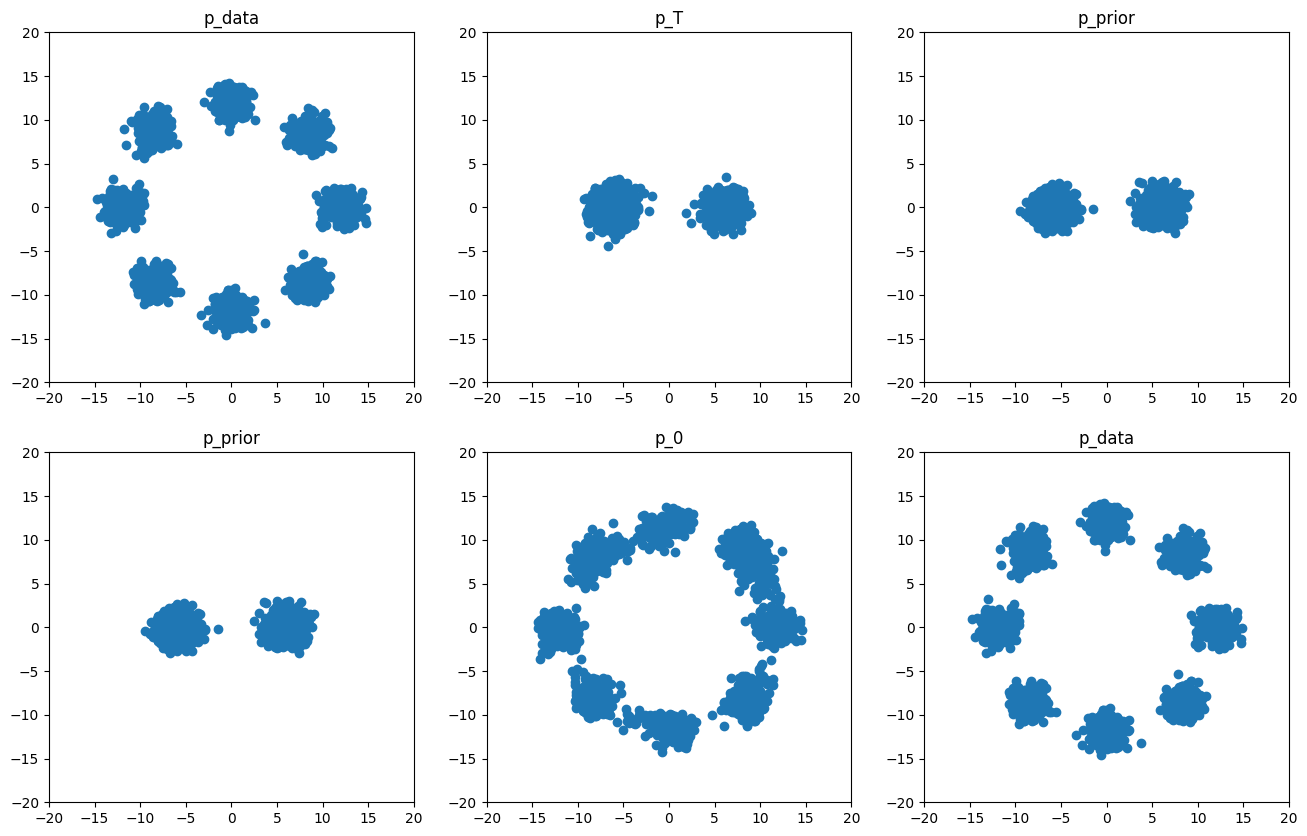

stage 14


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s, loss=5.09]


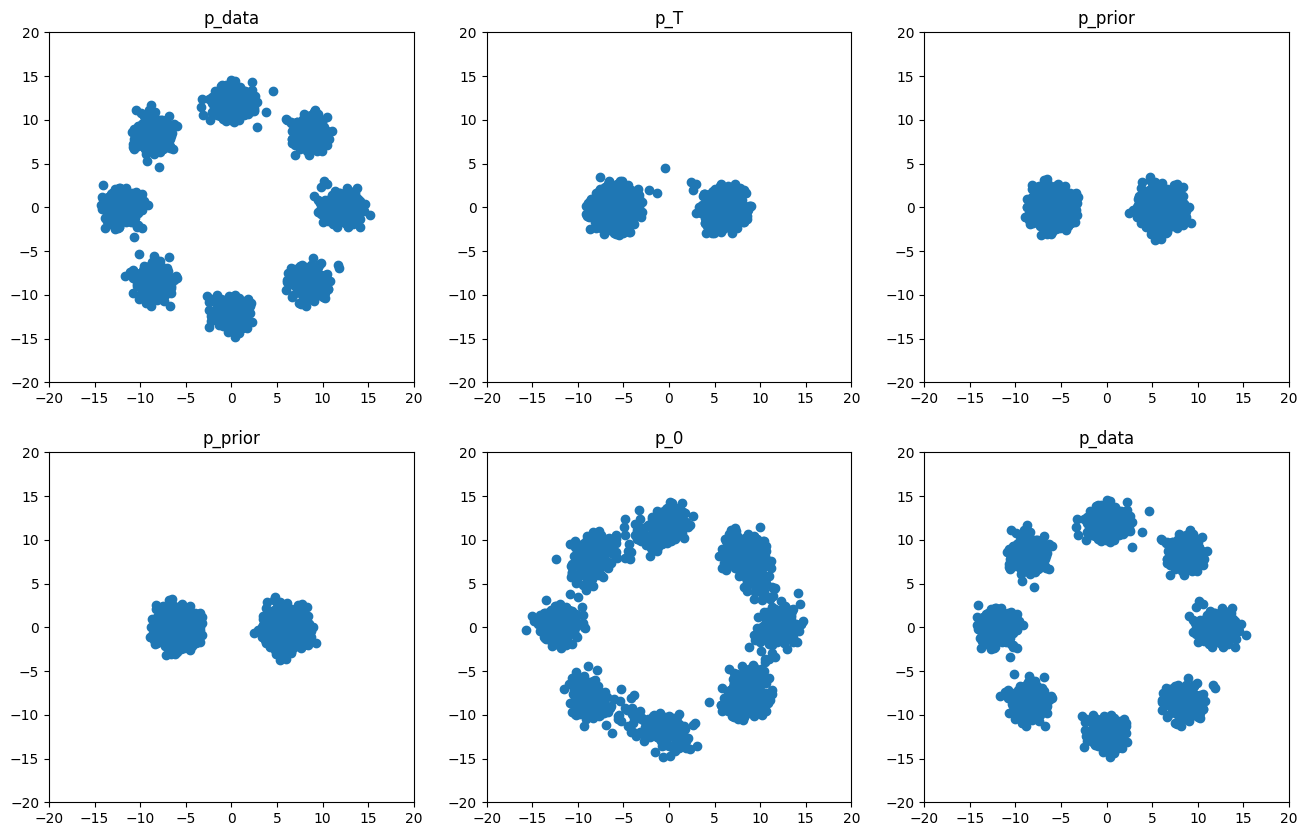

stage 15


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s, loss=4.96]


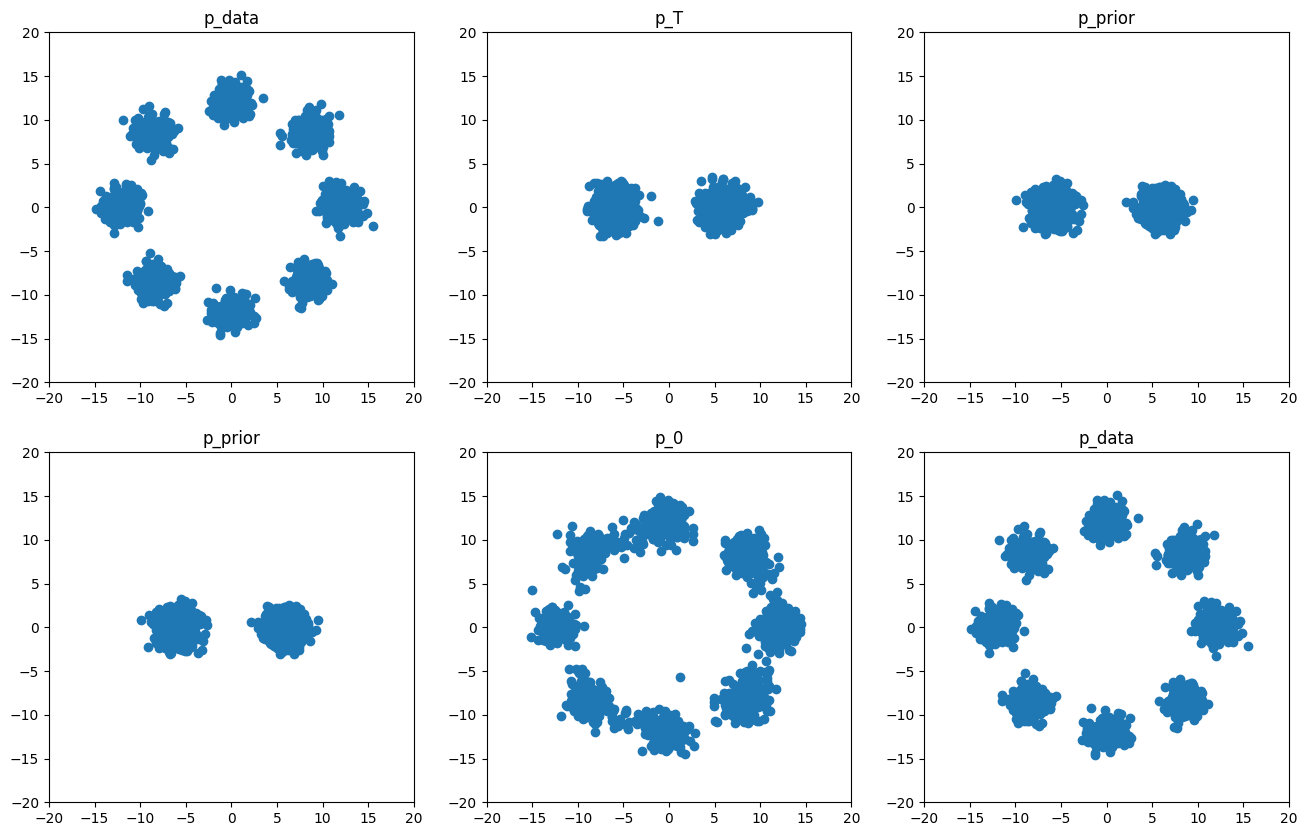

stage 16


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s, loss=5.15]


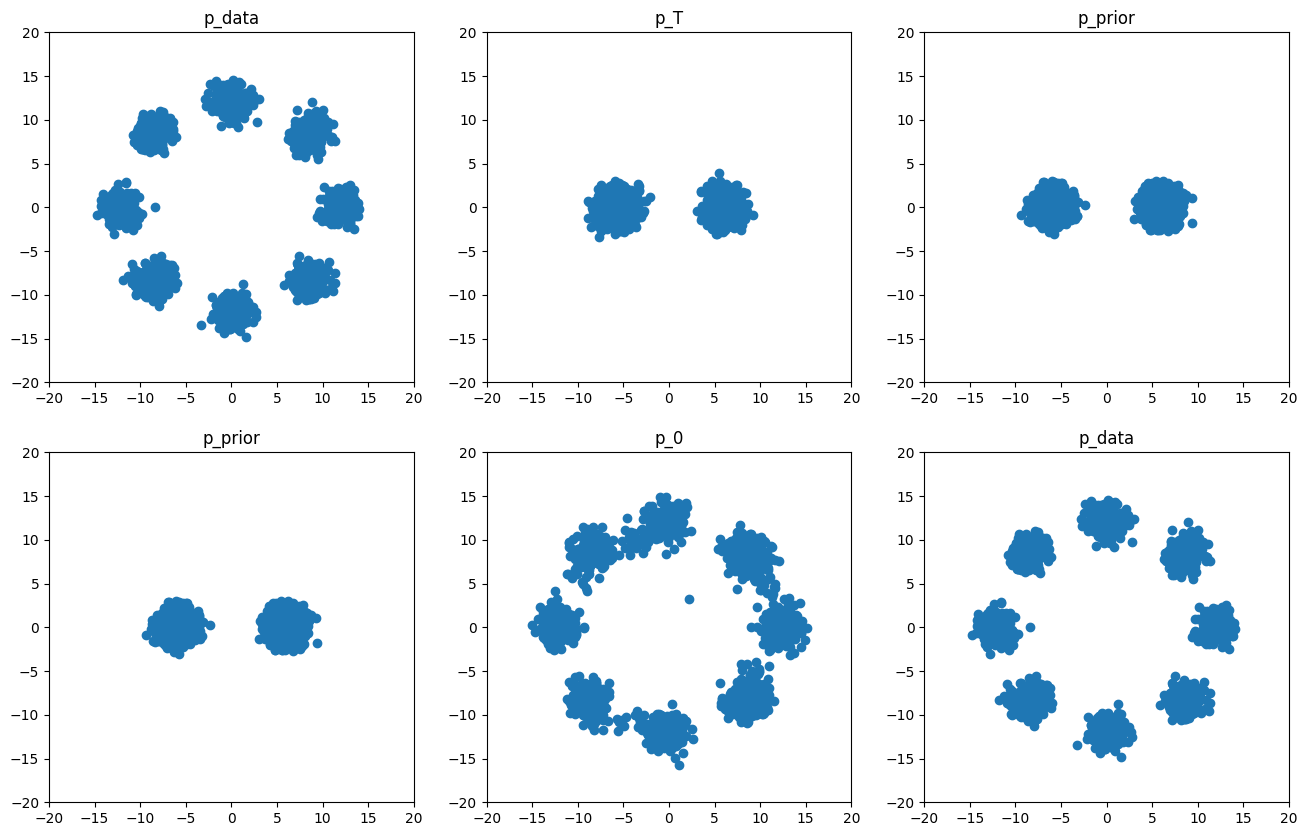

stage 17


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=4.87]


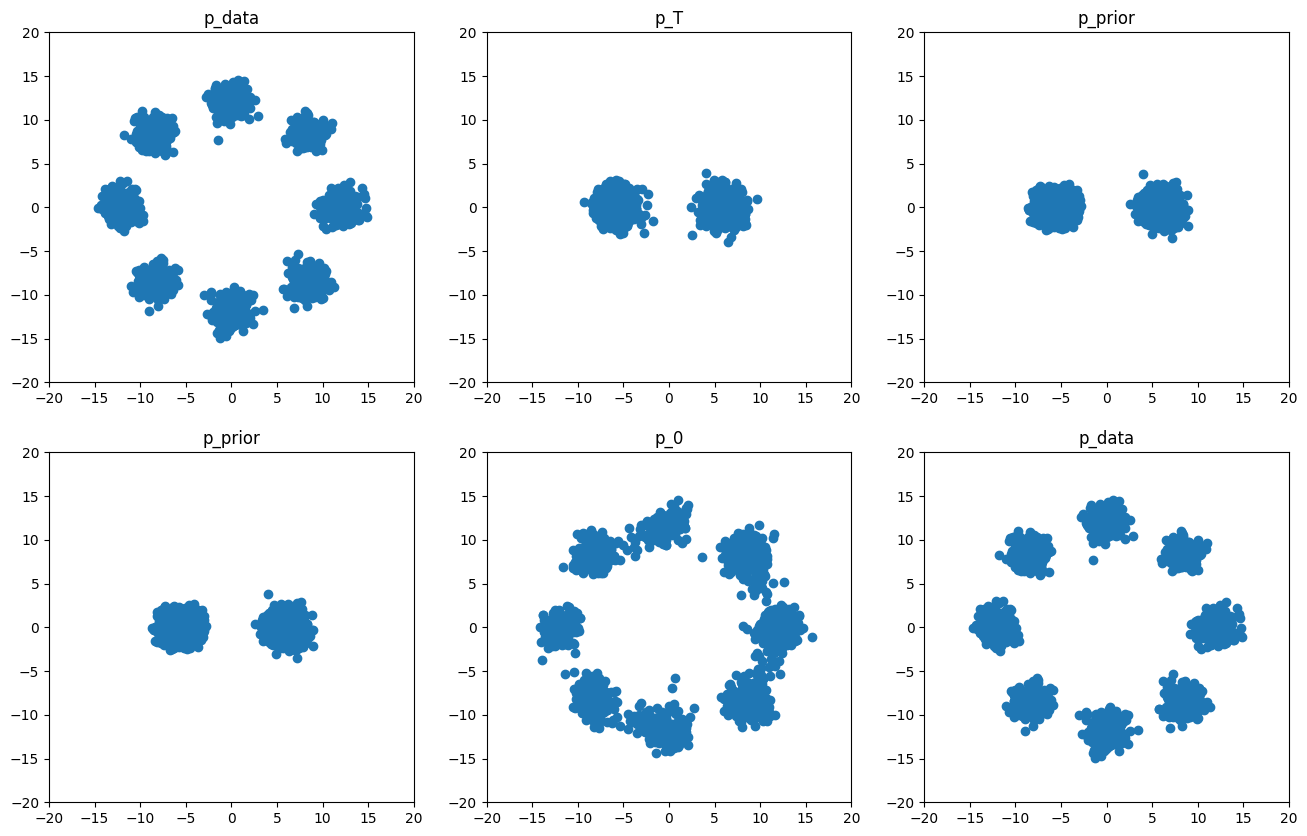

stage 18


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s, loss=5.24]


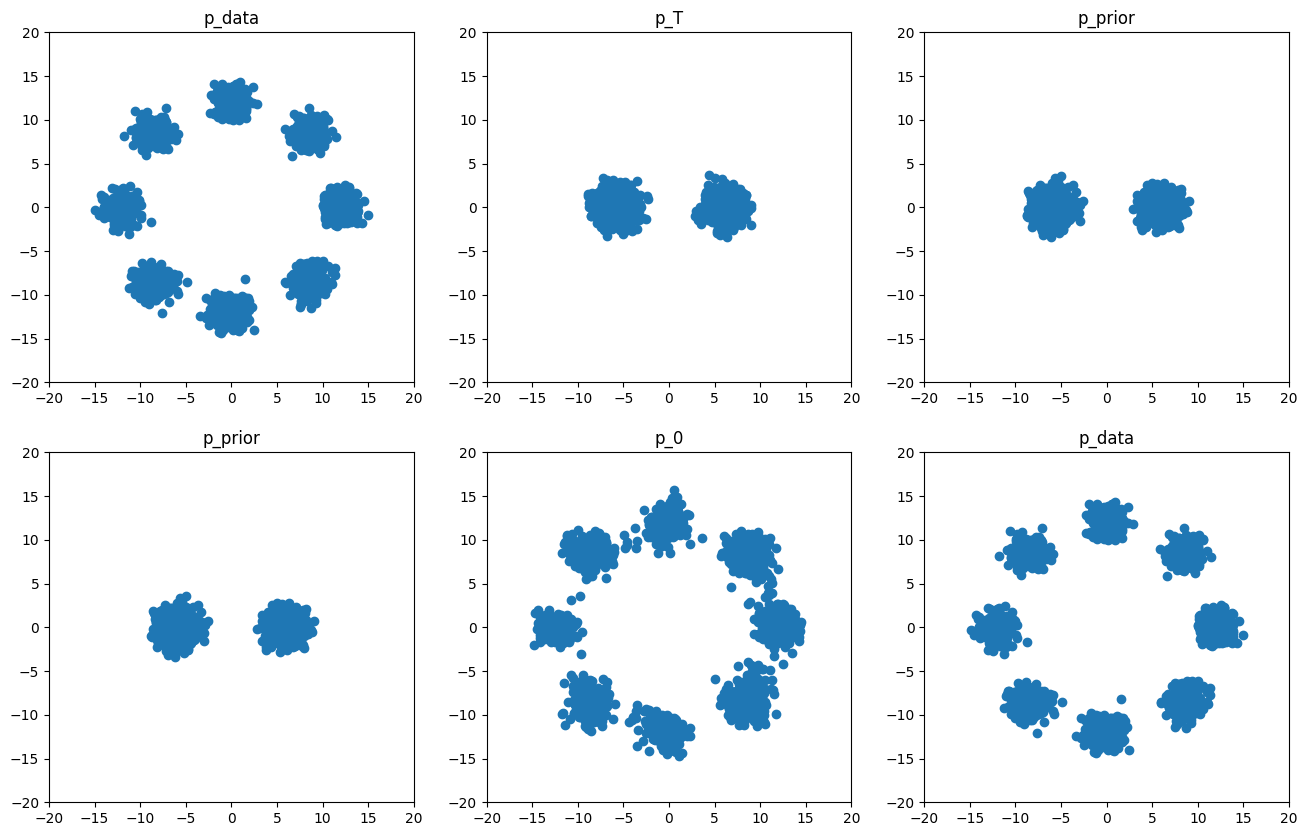

stage 19


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s, loss=5.04]


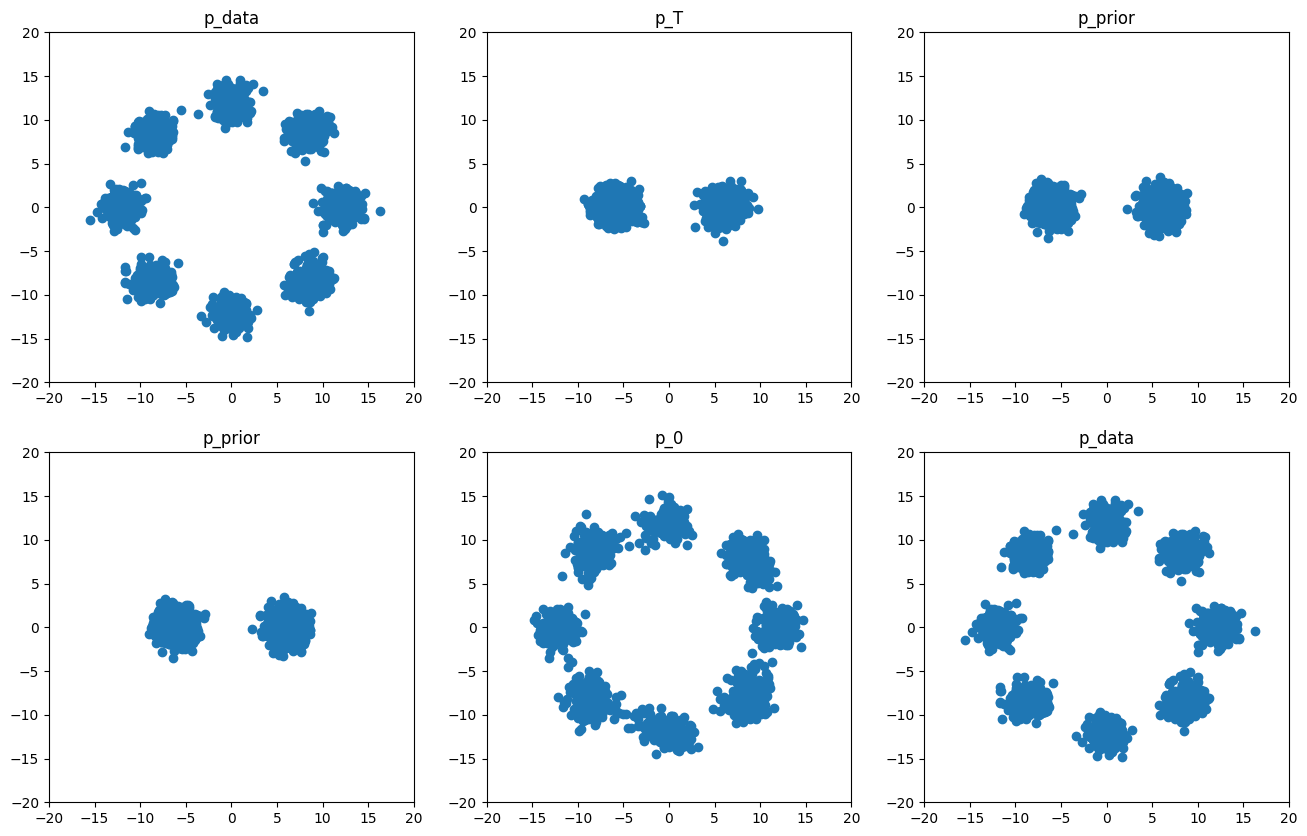

stage 20


Optimize theta: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s, loss=5.31]


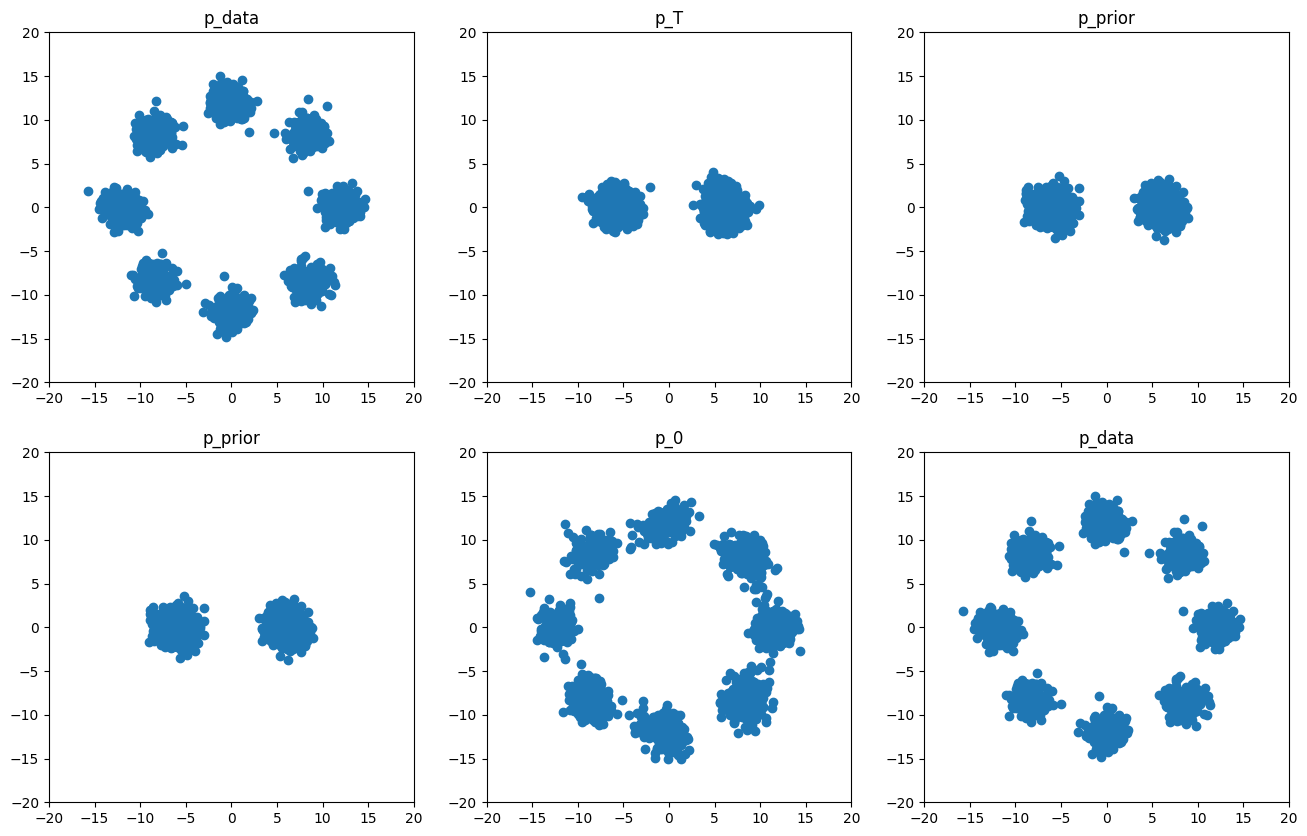

stage 21


Optimize phi:  19%|█▉        | 19/100 [00:05<00:22,  3.63it/s, loss=5.05]

In [9]:
train_and_plot_soc(each_num_step)

In [ ]:
# @title


class DOC(SDE):
    def forward_step(self, t, x, u=None):
        if u is None:
            u = 2 * self.net_u(t, x)
        dX = u * self.dt
        return x + dX

    def backward_step(self, t, x):
        s = self.net_s(t, x)
        dX = -s * self.dt
        return x - dX

    def _compute_loss(self):
        x, u, x_term = self.sample_traj()
        t = self.ts.repeat(batch_size)
        x = flatten_dim01(x)
        u = flatten_dim01(u)
        s = self.net_s(t, x)

        integrand = 0.5 * (2 * u + s) ** 2 + compute_div(s, x)
        E_integrand = integrand.reshape(
            x_term.shape[0], self.interval, x_term.shape[-1]
        ).mean(dim=0)
        loss = -self.p_prior.log_prob(x_term).mean() + (E_integrand * self.dt).sum()
        return loss

    def compute_loss_phi(self):
        return self._compute_loss()

    def compute_loss_theta(self):
        return self._compute_loss()


def train_and_plot_doc(each_num_step):
    doc = DOC(p_data, p_prior, device)
    doc.train(each_num_step)

In [ ]:
train_and_plot_doc(each_num_step)